In [22]:
import pandas as pd

# =========================
# 1. Load Excel files
# =========================
solar_df = pd.read_excel(r"D:\Ideathon\Solar_energy.xlsx")
wind_df = pd.read_excel(r"D:\Ideathon\wind_energy.xlsx")
biomass_df = pd.read_excel(r"D:\Ideathon\biomass.xlsx")
hydro_df = pd.read_excel(r"D:\Ideathon\hydro_energy.xlsx")
consumption_df = pd.read_excel(r"D:\Ideathon\maharashtra_area_average_load_MW.xlsx")

# =========================
# 2. Standardize column names
# =========================
solar_df.rename(columns={'Capacity in MW': 'solar_capacity_MW'}, inplace=True)
wind_df.rename(columns={'Sum_of_Contracted_Capacity_MW': 'wind_capacity_MW'}, inplace=True)
biomass_df.rename(columns={'Capacity in MW': 'biomass_capacity_MW'}, inplace=True)
hydro_df.rename(columns={'Capacity (MW)': 'hydro_capacity_MW'}, inplace=True)

# =========================
# 3. Fix numeric formatting (remove commas)
# =========================
for col in ['solar_capacity_MW']:
    solar_df[col] = solar_df[col].astype(str).str.replace(',', '').astype(float)

# =========================
# 4. Merge all datasets (area-wise)
# =========================
merged_df = consumption_df.copy()

merged_df = merged_df.merge(
    solar_df[['area_name', 'solar_capacity_MW']],
    on='area_name',
    how='left'
)

merged_df = merged_df.merge(
    wind_df[['area_name', 'wind_capacity_MW']],
    on='area_name',
    how='left'
)

merged_df = merged_df.merge(
    biomass_df[['area_name', 'biomass_capacity_MW']],
    on='area_name',
    how='left'
)

merged_df = merged_df.merge(
    hydro_df[['area_name', 'hydro_capacity_MW']],
    on='area_name',
    how='left'
)

# =========================
# 5. Replace NaN with 0
# =========================
merged_df.fillna(0, inplace=True)

# =========================
# 6. Drop unnecessary columns
# =========================
merged_df.drop(
    columns=['total_consumption_MU', 'estimated_consumption_kWh'],
    inplace=True,
    errors='ignore'
)

# =========================
# 7. Apply capacity factors (EFFECTIVE renewable power)
# =========================
merged_df['effective_solar_MW']   = merged_df['solar_capacity_MW']   * 0.20
merged_df['effective_wind_MW']    = merged_df['wind_capacity_MW']    * 0.30
merged_df['effective_biomass_MW'] = merged_df['biomass_capacity_MW'] * 0.80
merged_df['effective_hydro_MW']   = merged_df['hydro_capacity_MW']   * 0.40

merged_df['effective_renewable_MW'] = (
    merged_df['effective_solar_MW']
    + merged_df['effective_wind_MW']
    + merged_df['effective_biomass_MW']
    + merged_df['effective_hydro_MW']
)

# =========================
# 8. Compute TOTAL energy demand
# =========================
# average_load_MW is treated as GRID (conventional) usage
merged_df['total_energy_demand_MW'] = (
    merged_df['average_load_MW'] + merged_df['effective_renewable_MW']
)

# =========================
# 9. Grid dependency ratio (KEY FEATURE)
# =========================
merged_df['grid_dependency_ratio'] = (
    merged_df['average_load_MW'] / merged_df['total_energy_demand_MW']
)

merged_df['grid_dependency_ratio'] = merged_df['grid_dependency_ratio'].clip(0, 1)

# =========================
# 10. Save final clean Excel
# =========================
merged_df.to_excel(
    r"D:\Ideathon\maharashtra_energy_dependency_dataset.xlsx",
    index=False
)

print("✅ Energy dependency dataset generated successfully")

✅ Energy dependency dataset generated successfully


In [23]:
#1. Imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

#2. Load Prepared Dataset
df = pd.read_excel(
    r"D:\Ideathon\maharashtra_energy_dependency_dataset.xlsx"
)

In [24]:
#3. Feature Selection (FINAL)

FEATURE_COLS = [
    'grid_dependency_ratio',
]

X = df[FEATURE_COLS]

In [25]:
#4. Train–Test Split (for stability check)
X_train, X_test = train_test_split(
    X,
    test_size=0.25,
    random_state=42
)

#5. Feature Scaling (FIT ONLY ON TRAIN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#6. Train K-Means (TRAINING STEP)
kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

kmeans.fit(X_train_scaled)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",3
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",10
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [26]:
#7. Testing (Cluster Stability Check)
train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

print("Train cluster distribution:")
print(pd.Series(train_clusters).value_counts(normalize=True))

print("\nTest cluster distribution:")
print(pd.Series(test_clusters).value_counts(normalize=True))

Train cluster distribution:
1    0.521739
0    0.304348
2    0.173913
Name: proportion, dtype: float64

Test cluster distribution:
1    0.625
2    0.375
Name: proportion, dtype: float64


In [27]:
#8. Assign Clusters to Full Dataset
X_scaled_full = scaler.transform(X)
df['cluster'] = kmeans.predict(X_scaled_full)

#9. Auto-Interpret Clusters (VERY IMPORTANT)
cluster_means = (
    df.groupby('cluster')['grid_dependency_ratio']
    .mean()
    .sort_values()
)

cluster_mapping = {
    cluster_means.index[0]: 'Highly Self Dependent',
    cluster_means.index[1]: 'Moderately Dependent',
    cluster_means.index[2]: 'Highly Grid Dependent'
}

df['dependency_category'] = df['cluster'].map(cluster_mapping)

In [28]:
#10. SAVE MODEL & SCALER (FOR UI)
joblib.dump(
    kmeans,
    r"D:\Ideathon\energy_dependency_kmeans.pkl"
)

joblib.dump(
    scaler,
    r"D:\Ideathon\energy_dependency_scaler.pkl"
)

#11. Save Final Clustered Dataset
df.to_excel(
    r"D:\Ideathon\maharashtra_energy_clustered_final.xlsx",
    index=False
)

In [29]:
#12. Final Logs
print("✅ K-Means training completed")
print("✅ Model & scaler saved for UI usage")
print("✅ Final clustered dataset exported")

print("\nCluster-wise average grid dependency:")
print(cluster_means)

✅ K-Means training completed
✅ Model & scaler saved for UI usage
✅ Final clustered dataset exported

Cluster-wise average grid dependency:
cluster
1    0.530001
2    0.691290
0    0.980030
Name: grid_dependency_ratio, dtype: float64


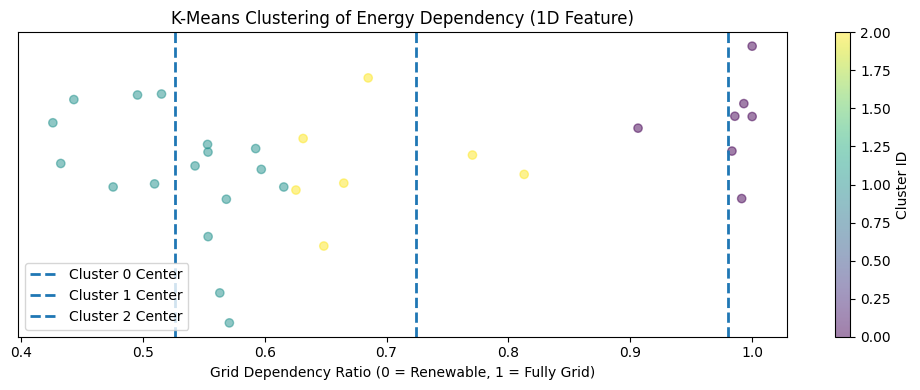

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -------------------------
# Assume df, kmeans, scaler already exist
# df must contain:
# - grid_dependency_ratio
# - cluster
# -------------------------

plt.figure(figsize=(10, 4))

# Add small jitter for visual separation
y_jitter = np.random.normal(0, 0.05, size=len(df))

# Scatter plot
scatter = plt.scatter(
    df['grid_dependency_ratio'],
    y_jitter,
    c=df['cluster'],
    cmap='viridis',
    alpha=0.5
)

# Plot cluster centers (inverse scaled)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, center in enumerate(centers):
    plt.axvline(
        x=center[0],
        linestyle='--',
        linewidth=2,
        label=f'Cluster {i} Center'
    )

plt.xlabel("Grid Dependency Ratio (0 = Renewable, 1 = Fully Grid)")
plt.yticks([])
plt.title("K-Means Clustering of Energy Dependency (1D Feature)")
plt.legend()
plt.colorbar(scatter, label="Cluster ID")

plt.tight_layout()
plt.show()
